In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import tqdm

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda")

True


In [3]:
from PIL import Image
from torch.utils.data import Dataset

class SateliteLabeledDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = os.getcwd() + data_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(self.data_dir + "\\images"))
                
    def __getitem__(self, index):
        image_name = self.image_names[index]
        mask_name = image_name.replace("sat", "mask")
        image_path = self.data_dir + "\\images\\" + image_name
        mask_path = self.data_dir + "\\masks\\" + mask_name
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

    def __len__(self):
        return len(self.image_names)


In [4]:
from torchvision import transforms
import torch.utils.data

transform = transforms.Compose([
    transforms.ToTensor()
])
data_dir_labeled = "\\labeled\\labeled"
data = SateliteLabeledDataset(data_dir=data_dir_labeled, transform=transform)
train_data, val_data = torch.utils.data.random_split(data, [0.8, 0.2])

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_data, batch_size=32, shuffle=True, drop_last=True
    )
val_loader = DataLoader(  
    dataset=val_data, batch_size=32, shuffle=False, drop_last=True
    )

In [6]:
# Helper functions
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop((200, 200)),
    transforms.Resize((256, 256))
])

def apply_transform(image, mask, mode):
    if mode == 'val':
        return image, transforms.Grayscale()(mask)
    elif mode == 'train':
        if len(image.shape) == 3:
            both_images = torch.cat((image.unsqueeze(0), mask.unsqueeze(0)), dim=0)
            transformed_images = augment(both_images)
            return transformed_images[0], transforms.Grayscale(num_output_channels=1)(transformed_images[1])
        elif len(image.shape) == 4:
            new_masks = torch.zeros((mask.shape[0], 1, mask.shape[2], mask.shape[3]))
            new_masks = new_masks.to(device)
            for i in range(image.shape[0]):
                simage = image[i, :, :, :]
                smask = mask[i, :, :, :]
                both_images = torch.cat((simage.unsqueeze(0), smask.unsqueeze(0)), dim=0)
                transformed_images = augment(both_images)
                image[i, :, :, :] = transformed_images[0]
                new_mask = transforms.Grayscale(num_output_channels=1)(transformed_images[1])
                new_masks[i] = new_mask
            return image, new_masks

def dice_coefficient(y_pred, y_true):
    eps = 1e-7
    y_pred = torch.sigmoid(y_pred)
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() + eps
    return 2.0 * intersection / union

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


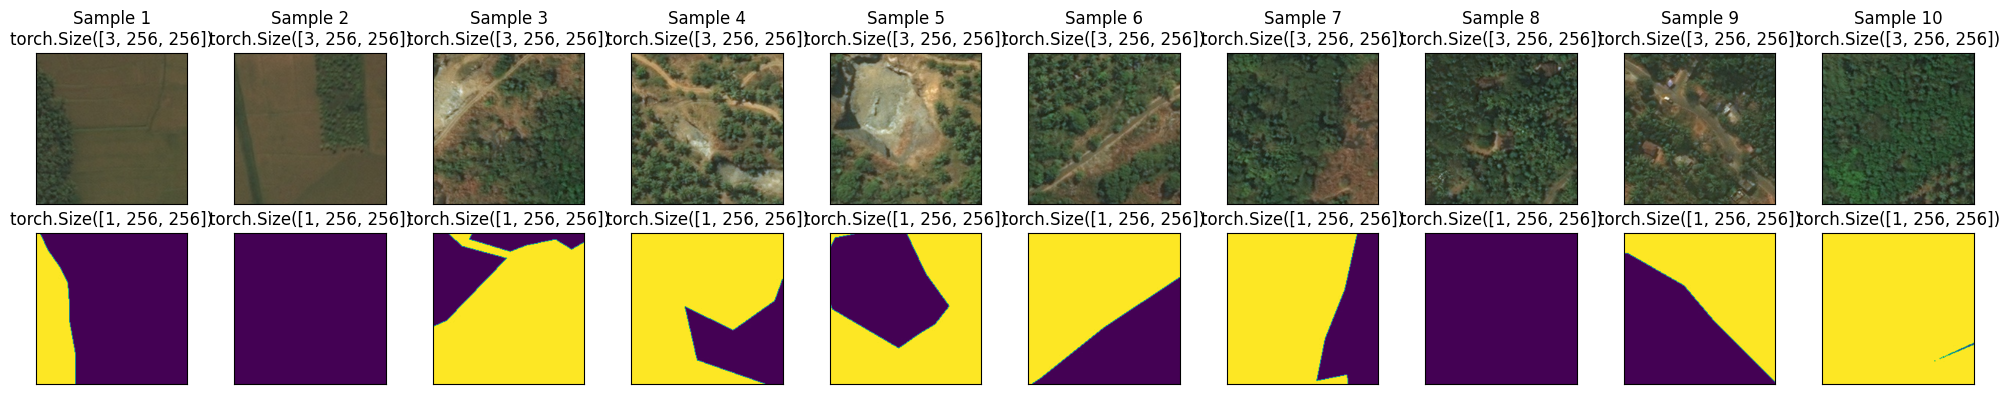

Size of the dataset: 4087


In [7]:
# Visualize images with transformations
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 4),
    subplot_kw={'xticks': [], 'yticks': []})
for i in range(10):
    img, mask = data[i]
    img, mask = apply_transform(img, mask, 'train')
    axs[0][i].imshow(img.permute(1, 2, 0))
    axs[0][i].set_title(f"Sample {i+1}\n{img.shape}")
    axs[1][i].imshow(mask.permute(1, 2, 0))
    axs[1][i].set_title(f"{mask.shape}")
plt.tight_layout()
plt.show()
print("Size of the dataset: {}".format(len(train_data)))

In [8]:
from torchvision.models import alexnet
print(alexnet().features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

class UNet1(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        self.scheduler_step_size = 10
        self.scheduler_gamma = 0.5
        self.encoder = alexnet(weights=None)
        self.encoder.classifier = nn.Identity()  # Remove fully connected layers
        self.decoder256 = nn.Sequential(
            nn.ConvTranspose2d(256, 192, kernel_size=3, stride=3, dilation=2, output_padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding="same"),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        self.decoder192 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=5, stride=3, dilation=2, output_padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.decoder64 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=11, stride=4, dilation=2),  # Output 1-channel prediction
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding="same"),
            nn.BatchNorm2d(1),
            nn.ReLU()
        ) 

        self.encoder.apply(weights_init)
        self.decoder256.apply(weights_init)
        self.decoder192.apply(weights_init)
        self.decoder64.apply(weights_init)

    def forward(self, x):
        # Encode
        # (*, 3, 256, 256) -> (*, 64, 31, 31)
        x1 = self.encoder.features[:3](x)
        # (*, 64, 31, 31) -> (*, 192, 15, 15)
        x2 = self.encoder.features[3:6](x1)
        # (*, 192, 15, 15) -> (*, 256, 15, 15)
        x3 = self.encoder.features[6:10](x2)
        # (*, 256, 15, 15) -> (*, 256, 7, 7)
        x4 = self.encoder.features[10:](x3)

        # Decode
        y = self.decoder256(F.interpolate(x4, x3.shape[2:]) + x3)
        y = self.decoder192(F.interpolate(y, x2.shape[2:]) + x2)
        y = self.decoder64(F.interpolate(y, x1.shape[2:]) + x1)
        return F.interpolate(y, (256, 256))

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'train')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('train_loss', loss)
        self.log('train_dice_coef', dice_coef)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'val')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('val_loss', loss)
        self.log('val_dice_coef', dice_coef)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return [optimizer], [scheduler]


In [94]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_summary import ModelSummary

model1 = UNet1()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=6, verbose=False, mode="min")
trainer = pl.Trainer(
    limit_train_batches=100, max_epochs=50, min_epochs=5, num_sanity_val_steps=2,
    default_root_dir=os.getcwd()+"\\checkpoints5", callbacks=[early_stop_callback, ModelSummary(max_depth=-1)]
)
trainer.fit(model=model1, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type              | Params
-----------------------------------------------------------
0  | encoder             | AlexNet           | 2.5 M 
1  | encoder.features    | Sequential        | 2.5 M 
2  | encoder.features.0  | Conv2d         

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|          | 0/15 [00:00<?, ?it/s] 

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 7: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it, v_num=15]


In [10]:
def plot_predictions(model:pl.LightningModule):
    model.eval()
    model.to(device)
    chosen_indices = np.random.choice(len(val_data), size=10, replace=False)
    images, masks = zip(*[val_data[i] for i in chosen_indices])

    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(16, 5))

    for i in range(10):
        image = images[i].numpy().transpose((1, 2, 0))
        mask = masks[i].numpy().transpose((1, 2, 0))
        axes[0][i].imshow(image)
        axes[0][i].set_title(f"Sample {i+1}")
        pred_mask = model(images[i].view(1, 3, 256, 256).to(device))
        pred_mask = torch.round(pred_mask)
        pred_mask = transforms.ToPILImage()(pred_mask[0])
        axes[1][i].imshow(mask)
        axes[1][i].set_title(f"Target")
        axes[2][i].imshow(pred_mask)
        axes[2][i].set_title(f"Prediction")

    # Hide the tick marks on the subplots
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()

C:\Users\angelo\AppData\Local\Temp\ipykernel_18320\1215753643.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


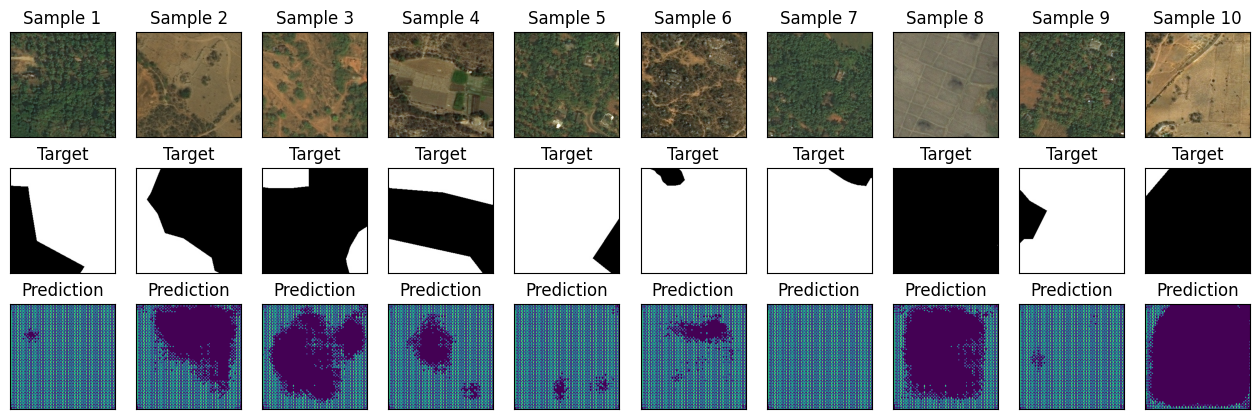

In [98]:
plot_predictions(model=model1)

In [11]:
from torchvision.models import vgg11_bn
print(vgg11_bn().features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [12]:
from torchvision.models import VGG11_BN_Weights

class UNet2(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        self.scheduler_step_size = 10
        self.scheduler_gamma = 0.5
        self.weights = VGG11_BN_Weights.DEFAULT
        self.encoder = vgg11_bn(weights=self.weights)
        self.encoder.classifier = nn.Identity()  # Remove fully connected layers
        self.decoder512 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.decoder256 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder128 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.decoder64 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),  # Output 1-channel prediction
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        ) 

        self.decoder512.apply(weights_init)
        self.decoder256.apply(weights_init)
        self.decoder128.apply(weights_init)
        self.decoder64.apply(weights_init)

    def forward(self, x):
        # Encode
        preprocess = self.weights.transforms()
        prep_x = preprocess(x)
        self.encoder.eval()
        with torch.no_grad():
            # (*, 3, 256, 256) -> (*, 64, 128, 128)
            x1 = self.encoder.features[:4](prep_x)
            # (*, 64, 128, 128) -> (*, 128, 64, 64)
            x2 = self.encoder.features[4:8](x1)
            # (*, 128, 64, 64) -> (*, 256, 32, 32)
            x3 = self.encoder.features[8:15](x2)
            # (*, 256, 32, 32) -> (*, 512, 16, 16)
            x4 = self.encoder.features[15:22](x3)
            # (*, 512, 16, 16) -> (*, 512, 8, 8)
            x5 = self.encoder.features[22:](x4)

        # Decode
        y = self.decoder512(F.interpolate(x5, x4.shape[2:]) + x4)
        y = self.decoder256(F.interpolate(y, x3.shape[2:]) + x3)
        y = self.decoder128(F.interpolate(y, x2.shape[2:]) + x2)
        y = self.decoder64(F.interpolate(y, x1.shape[2:]) + x1)
        return F.interpolate(y, (256, 256))

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'train')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('train_loss', loss)
        self.log('train_dice_coef', dice_coef)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'val')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('val_loss', loss)
        self.log('val_dice_coef', dice_coef)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return [optimizer], [scheduler]

In [101]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_summary import ModelSummary

model2 = UNet2()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=6, verbose=False, mode="min")
trainer = pl.Trainer(
    limit_train_batches=100, max_epochs=50, min_epochs=5, num_sanity_val_steps=2,
    default_root_dir=os.getcwd()+"\\checkpoints5", callbacks=[early_stop_callback, ModelSummary(max_depth=-1)]
)
trainer.fit(model=model2, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type              | Params
-----------------------------------------------------------
0  | encoder             | VGG               | 9.2 M 
1  | encoder.features    | Sequential        | 9.2 M 
2  | encoder.features.0  | Conv2d         

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s]

c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 16: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it, v_num=0]


C:\Users\angelo\AppData\Local\Temp\ipykernel_18320\1215753643.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


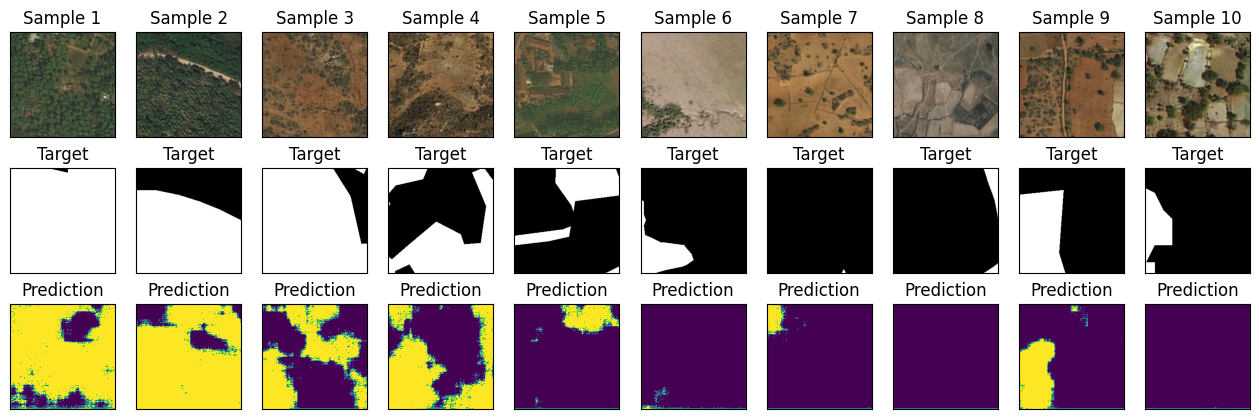

In [102]:
plot_predictions(model=model2)

In [13]:
import pandas as pd

def plot_from_csv(path):
    metrics = pd.read_csv(path)
    # Plot training and validation losses
    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.plot(metrics["train_loss"].dropna(), label='Train Loss')
    ax1.plot(metrics["val_loss"].dropna(), label='Validation Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    fig1.show()

    # Plot training and validation accuracies
    fig2, ax2 = plt.subplots(figsize=(6,6))
    ax2.plot(metrics["train_dice_coef"].dropna(), label='Train Dice Coefficient')
    ax2.plot(metrics["val_dice_coef"].dropna(), label='Validation Dice Coefficient')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    fig2.show()

In [46]:
torch.save(model2.state_dict(), os.getcwd()+"\\checkpoints5\\unet2.pt")

In [13]:
class SateliteUnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = os.getcwd() + data_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(self.data_dir))
                
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = self.data_dir + "\\" + image_name
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_names)


In [14]:
data_dir_unlabeled = "\\unlabeled\\unlabeled"
data = SateliteUnlabeledDataset(data_dir=data_dir_unlabeled, transform=transform)
unlabeled_train_data, unlabeled_val_data = torch.utils.data.random_split(data, [0.8, 0.2])

In [15]:
unlabeled_train_loader = DataLoader(
    dataset=unlabeled_train_data, batch_size=32, shuffle=True, drop_last=True
    )
unlabeled_val_loader = DataLoader(  
    dataset=unlabeled_val_data, batch_size=32, shuffle=False, drop_last=True
    )

In [16]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        self.scheduler_step_size = 10
        self.scheduler_gamma = 0.5

        # Each part of the branches initializes independently with Kaiming uniform
        self.left_branch = UNet1()
        self.right_branch = UNet1()

    def forward(self, x, step=1):
        if not self.training:
            out = self.left_branch(x)
            return out

        if step == 1:
            return self.left_branch(x)
        elif step == 2:
            return self.right_branch(x)

In [ ]:
# Things to track
train_losses = []
val_losses = []
train_dice_coefs = []
val_dice_coefs = []

In [19]:
# Hyper parameters
epochs = 50
model3 = UNet3()
#model3.load_state_dict(torch.load(os.getcwd() + "\\checkpoints5\\unet3v2.pt"))
model3.to(device)
left_optim = optim.Adam(params=model3.left_branch.parameters(), lr=model3.learning_rate)
right_optim = optim.Adam(params=model3.right_branch.parameters(), lr=model3.learning_rate)
left_scheduler = StepLR(left_optim, step_size=model3.scheduler_step_size, gamma=model3.scheduler_gamma)
right_scheduler = StepLR(right_optim, step_size=model3.scheduler_step_size, gamma=model3.scheduler_gamma)
criterion = F.binary_cross_entropy_with_logits
steps_per_epoch = 50

# Training loop
model3.train()
for epoch in tqdm.tqdm(range(epochs)):
    supervised_train_iter = iter(train_loader)
    unsupervised_train_iter = iter(unlabeled_train_loader)
    supervised_val_iter = iter(val_loader)
    unsupervised_val_iter = iter(unlabeled_val_loader)
    for step in tqdm.tqdm(range(min(steps_per_epoch, len(train_loader)))):
        left_optim.zero_grad()
        right_optim.zero_grad()

        # Retrieve batch images and labels
        x_labeled, y = next(supervised_train_iter)
        x_unlabeled = next(unsupervised_train_iter)
        x_labeled = x_labeled.to(device)
        y = y.to(device)
        x_unlabeled = x_unlabeled.to(device)

        # Augmentation
        x_labeled, y = apply_transform(x_labeled, y, 'train')
        x_unlabeled = augment(x_unlabeled)

        # Forward
        left_pred_supervised = model3(x_labeled, step=1)
        right_pred_supervised = model3(x_labeled, step=2)
        torch.cuda.empty_cache()
        left_pred_unsupervised = model3(x_unlabeled, step=1)
        right_pred_unsupervised = model3(x_unlabeled, step=2)
        torch.cuda.empty_cache()

        # Loss
        left_pred = torch.cat([left_pred_supervised, left_pred_unsupervised], dim=0)
        right_pred = torch.cat([right_pred_supervised, right_pred_unsupervised], dim=0)
        _, max_left = torch.max(left_pred, dim=1)
        _, max_right = torch.max(right_pred, dim=1)
        max_left = max_left.view((len(x_labeled)*2, 1, 256, 256)).float()
        max_right = max_right.view((len(x_labeled)*2, 1, 256, 256)).float()
        cps_loss = criterion(left_pred, max_right) + criterion(right_pred, max_left)
        left_supervised_loss = criterion(left_pred_supervised, y)
        right_supervised_loss = criterion(right_pred_supervised, y)
        loss = cps_loss + left_supervised_loss + right_supervised_loss
        left_dice_coef = dice_coefficient(left_pred_supervised, y)
        right_dice_coef = dice_coefficient(right_pred_supervised, y)
        dice_coef = (left_dice_coef + right_dice_coef) / 2

        train_losses.append(loss.cpu().detach().item())
        train_dice_coefs.append(dice_coef)

        loss.backward()

        left_optim.step()
        right_optim.step()
        left_scheduler.step()
        right_scheduler.step()
    
    # Check for validation data
    with torch.no_grad():
        for step in tqdm.tqdm(range(min(steps_per_epoch, int(len(val_loader))))):
            # Retrieve batch images and labels
            x_labeled, y = next(supervised_val_iter)
            x_unlabeled = next(unsupervised_val_iter)
            x_labeled = x_labeled.to(device)
            y = y.to(device)
            x_unlabeled = x_unlabeled.to(device)

            # Transformation
            x_labeled, y = apply_transform(x_labeled, y, 'val')

            # Forward
            left_pred_supervised = model3(x_labeled, step=1)
            right_pred_supervised = model3(x_labeled, step=2)
            left_pred_unsupervised = model3(x_unlabeled, step=1)
            right_pred_unsupervised = model3(x_unlabeled, step=2)
            torch.cuda.empty_cache()

            # Loss
            left_pred = torch.cat([left_pred_supervised, left_pred_unsupervised], dim=0)
            right_pred = torch.cat([right_pred_supervised, right_pred_unsupervised], dim=0)
            _, max_left = torch.max(left_pred, dim=1)
            _, max_right = torch.max(right_pred, dim=1)
            max_left = max_left.view((len(x_labeled)*2, 1, 256, 256)).float()
            max_right = max_right.view((len(x_labeled)*2, 1, 256, 256)).float()
            cps_loss = criterion(left_pred, max_right) + criterion(right_pred, max_left)
            left_supervised_loss = criterion(left_pred_supervised, y)
            right_supervised_loss = criterion(right_pred_supervised, y)
            loss = cps_loss + left_supervised_loss + right_supervised_loss
            left_dice_coef = dice_coefficient(left_pred_supervised, y)
            right_dice_coef = dice_coefficient(right_pred_supervised, y)
            dice_coef = (left_dice_coef + right_dice_coef) / 2

            val_losses.append(loss.cpu().detach().item())
            val_dice_coefs.append(dice_coef)
    torch.save(model3.state_dict(), os.getcwd()+"\\checkpoints5\\unet3v2")

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 14%|█▍        | 7/50 [04:51<29:49, 41.62s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 12.00 GiB total capacity; 10.48 GiB already allocated; 0 bytes free; 11.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
def plot_from_lists():
    # Plot training and validation losses
    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    fig1.show()

    # Plot training and validation dice coefficients
    fig2, ax2 = plt.subplots(figsize=(6,6))
    ax2.plot(train_dice_coefs, label='Train Dice Coefficient')
    ax2.plot(val_dice_coefs, label='Validation Dice Coefficient')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    fig2.show()

C:\Users\angelo\AppData\Local\Temp\ipykernel_21512\2595076759.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\angelo\AppData\Local\Temp\ipykernel_21512\2595076759.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


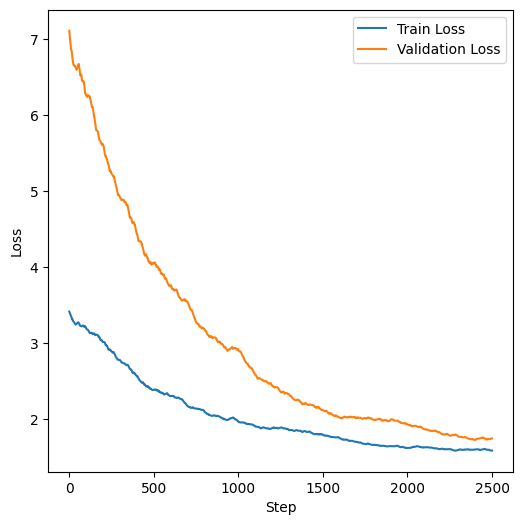

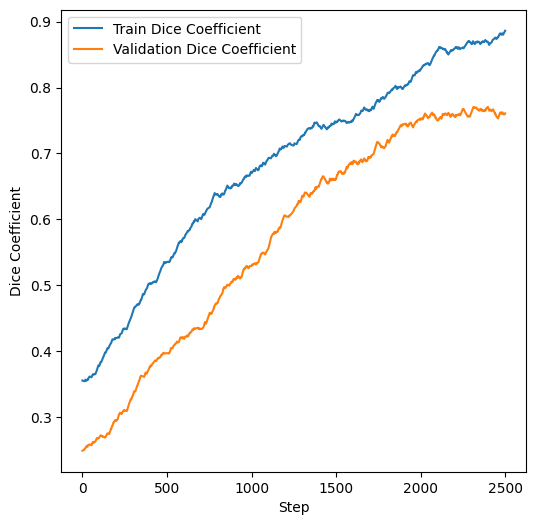

In [63]:
plot_from_lists()

C:\Users\angelo\AppData\Local\Temp\ipykernel_15756\106194243.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


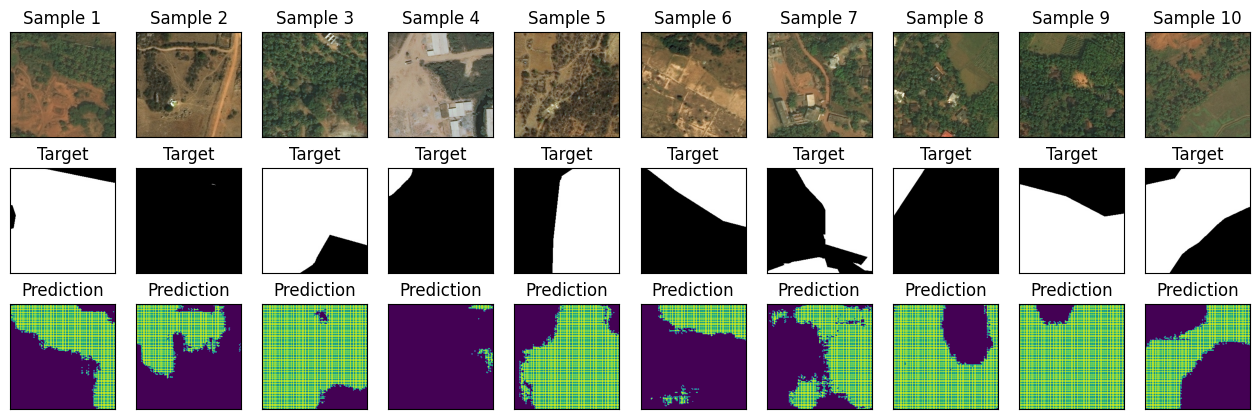

In [45]:
model3 = UNet3()
model3.load_state_dict(torch.load(os.getcwd() + "\\checkpoints5\\unet3v2.pt"))
plot_predictions(model=model3)

In [18]:
import random

class JigsawDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = os.getcwd() + data_dir
        self.image_names = sorted(os.listdir(self.data_dir))

        self.__image_transformer = transforms.Compose([
            transforms.Resize(256, Image.BILINEAR),
            transforms.CenterCrop(255)])
        self.__augment_tile = transforms.Compose([
            transforms.RandomCrop(64),
            transforms.Resize((75, 75), Image.BILINEAR),
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = self.data_dir + "\\" + image_name
        image = Image.open(image_path).convert('RGB')

        if image.size[0] != 255:
            image = self.__image_transformer(image)

        s = float(image.size[0]) / 3
        a = s / 2
        tiles = [None] * 9
        for n in range(9):
            i = n / 3
            j = n % 3
            c = [a * i * 2 + a, a * j * 2 + a]
            c = np.array([c[1] - a, c[0] - a, c[1] + a + 1, c[0] + a + 1]).astype(int)
            tile = image.crop(c.tolist())
            tile = self.__augment_tile(tile)
            # Normalize the patches indipendently to avoid low level features shortcut
            m, s = tile.view(3, -1).mean(dim=1).numpy(), tile.view(3, -1).std(dim=1).numpy()
            s[s == 0] = 1
            norm = transforms.Normalize(mean=m.tolist(), std=s.tolist())
            tile = norm(tile)
            tiles[n] = tile

        permutation_label = random.sample(range(9), 9)
        data = [tiles[permutation_label[t]] for t in range(9)]
        data = torch.stack(data, 0)

        return data, torch.tensor(permutation_label, dtype=torch.float32)

    def __len__(self):
        return len(self.image_names)

In [19]:
data_dir_unlabeled = "\\unlabeled\\unlabeled"
data = JigsawDataset(data_dir=data_dir_unlabeled)
jigsaw_train_data, jigsaw_val_data = torch.utils.data.random_split(data, [0.8, 0.2])

In [32]:
jigsaw_train_loader = DataLoader(
    dataset=jigsaw_train_data, batch_size=64, shuffle=True, drop_last=True
    )
jigsaw_val_loader = DataLoader(  
    dataset=jigsaw_val_data, batch_size=64, shuffle=False
    )

In [33]:
class ContextEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        self.scheduler_step_size = 10
        self.scheduler_gamma = 0.5
        self.encoder = alexnet(weights=None)
        self.encoder.classifier = nn.Identity()  # Remove fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.ReLU()
        )

        self.encoder.apply(weights_init)
        self.fc.apply(weights_init)

    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.encoder(x[i])
            z = self.fc(z.view(B, -1))
            z = z.view([B, 1, -1])
            x_list.append(z)

        x = torch.cat(x_list,1)
        x = x.view(B, 9)
        return x

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        rounded_y_pred = torch.round(y_pred)
        correct_tiles = (rounded_y_pred == y_true).sum().item()
        self.log('train_loss', loss)
        self.log('train_acc', correct_tiles / (9*x.size(0)))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y_true)
        rounded_y_pred = torch.round(y_pred)
        correct_tiles = (rounded_y_pred == y_true).sum().item()
        self.log('val_loss', loss)
        self.log('val_acc', correct_tiles / (9*x.size(0)))

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return [optimizer], [scheduler]


In [34]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_summary import ModelSummary

encoder = ContextEncoder()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.009, patience=6, verbose=False, mode="min")
trainer = pl.Trainer(
    limit_train_batches=100, max_epochs=60, min_epochs=5, num_sanity_val_steps=2,
    default_root_dir=os.getcwd()+"\\checkpoints5", callbacks=[early_stop_callback, ModelSummary(max_depth=-1)]
)
trainer.fit(model=encoder, train_dataloaders=jigsaw_train_loader, val_dataloaders=jigsaw_val_loader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type              | Params
-----------------------------------------------------------
0  | encoder             | AlexNet           | 2.5 M 
1  | encoder.features    | Sequential        | 2.5 M 
2  | encoder.features.0  | Conv2d         

Epoch 16: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s, v_num=0]       


In [35]:
torch.save(encoder.state_dict(), os.getcwd()+"\\checkpoints5\\encoderv2.pt")

In [40]:
class UNet4(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        self.scheduler_step_size = 10
        self.scheduler_gamma = 0.5
        self.encoder = ContextEncoder()
        self.encoder.load_state_dict(torch.load(os.getcwd() + "\\checkpoints5\\encoderv2.pt"))
        self.encoder.fc = nn.Identity()
        self.decoder256 = nn.Sequential(
            nn.ConvTranspose2d(256, 192, kernel_size=3, stride=3, dilation=2, output_padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding="same"),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        self.decoder192 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=5, stride=3, dilation=2, output_padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.decoder64 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=11, stride=4, dilation=2),  # Output 1-channel prediction
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding="same"),
            nn.BatchNorm2d(1),
            nn.ReLU()
        ) 

        self.decoder256.apply(weights_init)
        self.decoder192.apply(weights_init)
        self.decoder64.apply(weights_init)

    def forward(self, x):
        # Encode
        self.encoder.eval()
        with torch.no_grad():
            # (*, 3, 256, 256) -> (*, 64, 31, 31)
            x1 = self.encoder.encoder.features[:3](x)
            # (*, 64, 31, 31) -> (*, 192, 15, 15)
            x2 = self.encoder.encoder.features[3:6](x1)
            # (*, 192, 15, 15) -> (*, 256, 15, 15)
            x3 = self.encoder.encoder.features[6:10](x2)
            # (*, 256, 15, 15) -> (*, 256, 7, 7)
            x4 = self.encoder.encoder.features[10:](x3)

        # Decode
        y = self.decoder256(F.interpolate(x4, x3.shape[2:]) + x3)
        y = self.decoder192(F.interpolate(y, x2.shape[2:]) + x2)
        y = self.decoder64(F.interpolate(y, x1.shape[2:]) + x1)
        return F.interpolate(y, (256, 256))

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'train')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('train_loss', loss)
        self.log('train_dice_coef', dice_coef)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        x, y_true = apply_transform(x, y_true, 'val')
        y_pred = self(x)
        loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice_coef = dice_coefficient(y_pred, y_true)
        self.log('val_loss', loss)
        self.log('val_dice_coef', dice_coef)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = StepLR(optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return [optimizer], [scheduler]


In [41]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_summary import ModelSummary

model4 = UNet4()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=6, verbose=False, mode="min")
trainer = pl.Trainer(
    limit_train_batches=100, max_epochs=60, min_epochs=5, num_sanity_val_steps=2,
    default_root_dir=os.getcwd()+"\\checkpoints5", callbacks=[early_stop_callback, ModelSummary(max_depth=-1)]
)
trainer.fit(model=model4, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                        | Type              | Params
-------------------------------------------------------------------
0  | encoder                     | ContextEncoder    | 2.5 M 
1  | encoder.encoder             | AlexNet           | 2.5 M 
2  | encod

Epoch 17: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s, v_num=0]        


In [42]:
torch.save(model4.state_dict(), os.getcwd()+"\\checkpoints5\\unet4v2.pt")

C:\Users\angelo\AppData\Local\Temp\ipykernel_15756\106194243.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


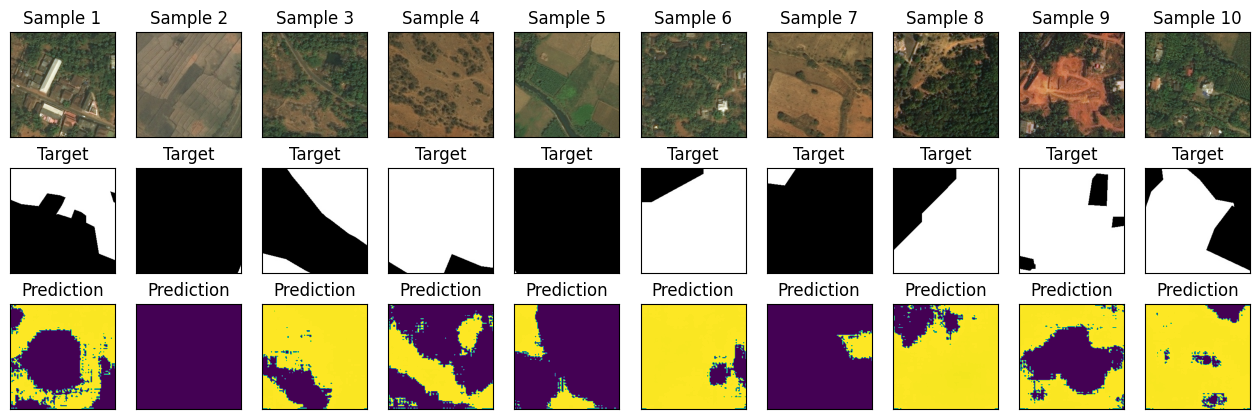

In [50]:
model4 = UNet4()
model4.load_state_dict(torch.load(os.getcwd() + "\\checkpoints5\\unet4v1.pt"))
plot_predictions(model=model4)